# 목차
- 1. Library, Data

- 2. user_spec
  - 2.1. user_spec EDA
    - 2.1.1. company_enter_month 날짜형식 확인
    - 2.1.2. 결측치 확인
    - 2.1.3. 개인 회생자 여부/개인회생자 납입 완료 여부 시각화
    - 2.1.4. 기대출수, 기대출 금액 시각화
    - 2.1.5. yearly_income 결측치 확인

  - 2.2. user_spec 전처리

- 3. 고객 군집 분석
  - 3.1. log_data 전처리: event 빈도 합계 테이블로 변환
  - 3.2. log_data 전처리: event 발생 비율로 변환
  - 3.3. K-Means + Elbow Method
  - 3.4. Clustering 결과
  - 3.5. 군집 별 log_data 시각화
  - 3.6. 군집 별 user_spec 시각화

# 1. Library, Data

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 12 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (48.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#한글폰트 설정
from matplotlib import font_manager, rc
sns.set_style('darkgrid')
plt.rc('font', family='NanumGothic')

Mounted at /content/drive


In [ ]:
user_spec = pd.read_csv('/content/drive/MyDrive/13. 빅콘테스트 2022/data/user_spec.csv')
user_spec = user_spec.sort_values(['user_id','insert_time']) # 데이터 정렬 
log_data = pd.read_csv('/content/drive/MyDrive/13. 빅콘테스트 2022/data/log_data.csv')

# 2. user_spec

## 2.1. user_spec EDA

### 2.1.1. company_enter_month 날짜 format 확인


- company_enter_month의 format이 yyyymm 또는 yyyymmdd으로 두가지 존재

In [ ]:
user_spec[user_spec.user_id == 10768].sort_values('insert_time')[-9:-5]

,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
499265,1661442,10768,1993.0,0.0,2022-05-20 15:59:41,590.0,39000000.0,EARNEDINCOME,202202.0,정규직,전월세,50000000.0,대환대출,0.0,0.0,1.0,NaN
1003719,1394760,10768,1993.0,0.0,2022-05-29 00:54:52,590.0,39000000.0,EARNEDINCOME,202202.0,정규직,전월세,39000000.0,생활비,0.0,0.0,1.0,NaN
1048216,237405,10768,1993.0,0.0,2022-06-06 22:00:19,590.0,39000000.0,EARNEDINCOME,20220201.0,정규직,전월세,39000000.0,대환대출,0.0,0.0,1.0,NaN
36515,1525682,10768,1993.0,0.0,2022-06-10 00:53:57,590.0,39000000.0,EARNEDINCOME,20220201.0,정규직,전월세,50000000.0,대환대출,0.0,0.0,1.0,NaN


### 2.1.2 결측치 확인

In [ ]:
user_spec.isna().sum()

application_id                               0
user_id                                      0
birth_year                               12961
gender                                   12961
insert_time                                  0
credit_score                            105115
yearly_income                               90
income_type                                 85
company_enter_month                     171760
employment_type                             85
houseown_type                               85
desired_amount                              85
purpose                                     85
personal_rehabilitation_yn              587461
personal_rehabilitation_complete_yn    1203354
existing_loan_cnt                       198556
existing_loan_amt                       313774
dtype: int64

### 2.1.3. 개인 회생자 여부/개인회생자 납입 완료 여부 시각화

- 데이터 개수 차이가 심했음 
- 개인회생 변수들에 따라 existing_loan_cnt, existing_loan_amt의 분위수 차이가 있었음
- 분위수가 비슷한 경우 같은 집단으로 보임 
- 0.0/nan, nan/nan, 0/0 -> 개인회생자가 아닌 경우로 생각
- '0.0/1.0'인 경우의 user_id 확인했을때 4명 존재 -> 추출해서 확인했을때 0.0/NaN으로 바뀌었음 경우가 있었음 따라서 개인회생자가 아닌 경우로 생각

In [ ]:
user_spec['personal_rehabilitation'] = user_spec['personal_rehabilitation_yn'].astype(str) + '/' +user_spec['personal_rehabilitation_complete_yn'].astype(str)

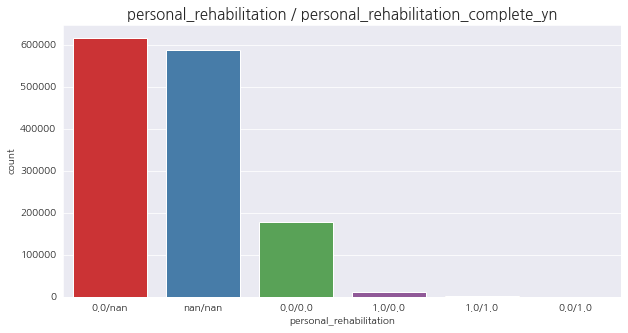

In [ ]:
plt.figure(figsize=(10, 5)) # 가로, 세로 
sns.countplot(x='personal_rehabilitation', palette='Set1', data=user_spec)
plt.title('personal_rehabilitation / personal_rehabilitation_complete_yn', fontsize=15)
plt.show()

Text(0.5, 1.0, 'existing_loan_cnt boxplot')

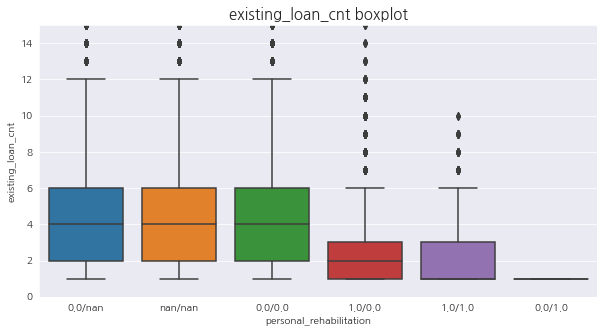

In [ ]:
plt.figure(figsize=(10, 5)) # 가로, 세로 
sns.boxplot(x='personal_rehabilitation', y='existing_loan_cnt', data=user_spec) 
plt.ylim([0, 1.5*1e1])
plt.title('existing_loan_cnt boxplot', fontsize=15)

Text(0.5, 1.0, 'existing_loan_amt boxplot')

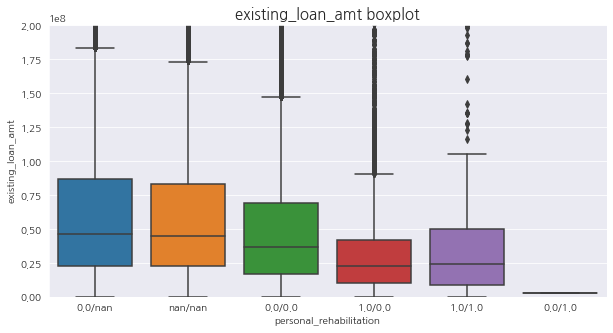

In [ ]:
plt.figure(figsize=(10, 5)) # 가로, 세로 
sns.boxplot(x='personal_rehabilitation', y='existing_loan_amt', data=user_spec) 
plt.ylim([0, 2*1e8])
plt.title('existing_loan_amt boxplot', fontsize=15)

In [ ]:
user_spec[user_spec.personal_rehabilitation == '0.0/1.0']

,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,personal_rehabilitation
1319216,1624053,24030,1981.0,1.0,2022-05-13 00:23:08,650.0,32000000.0,EARNEDINCOME,202204.0,정규직,기타가족소유,5000000.0,생활비,0.0,1.0,1.0,3000000.0,0.0/1.0
94465,1574646,39991,1981.0,0.0,2022-04-21 13:14:59,600.0,22000000.0,EARNEDINCOME,201703.0,계약직,전월세,4000000.0,생활비,0.0,1.0,1.0,NaN,0.0/1.0
139885,1065260,598997,1988.0,1.0,2022-05-17 19:42:47,NaN,15000000.0,PRIVATEBUSINESS,201706.0,기타,전월세,10000000.0,생활비,0.0,1.0,NaN,NaN,0.0/1.0
84244,1501280,855482,2002.0,1.0,2022-06-06 21:01:14,NaN,1000000.0,OTHERINCOME,NaN,기타,기타가족소유,0.0,생활비,0.0,1.0,NaN,NaN,0.0/1.0


In [ ]:
user_spec[user_spec.user_id == 24030].sort_values('insert_time')

,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,personal_rehabilitation
1357315,1058737,24030,1981.0,1.0,2022-03-02 12:56:51,570.0,25000000.0,OTHERINCOME,202107.0,기타,기타가족소유,2000000.0,대환대출,NaN,NaN,1.0,3000000.0,nan/nan
246291,1884845,24030,1981.0,1.0,2022-03-02 13:04:26,570.0,25000000.0,OTHERINCOME,202107.0,기타,기타가족소유,2000000.0,대환대출,NaN,NaN,1.0,3000000.0,nan/nan
921273,1304895,24030,1981.0,1.0,2022-04-27 15:48:02,670.0,40000000.0,EARNEDINCOME,202204.0,정규직,기타가족소유,15000000.0,대환대출,0.0,NaN,1.0,3000000.0,0.0/nan
1342936,609971,24030,1981.0,1.0,2022-05-12 23:18:25,650.0,32000000.0,EARNEDINCOME,202204.0,정규직,기타가족소유,2000000.0,생활비,1.0,1.0,1.0,3000000.0,1.0/1.0
1319216,1624053,24030,1981.0,1.0,2022-05-13 00:23:08,650.0,32000000.0,EARNEDINCOME,202204.0,정규직,기타가족소유,5000000.0,생활비,0.0,1.0,1.0,3000000.0,0.0/1.0
919472,1779230,24030,1981.0,1.0,2022-05-16 16:56:45,650.0,35000000.0,EARNEDINCOME,202204.0,정규직,기타가족소유,5000000.0,생활비,0.0,NaN,1.0,3000000.0,0.0/nan
1362440,125057,24030,1981.0,1.0,2022-05-18 01:33:55,650.0,35000000.0,EARNEDINCOME,202204.0,정규직,기타가족소유,15000000.0,생활비,0.0,NaN,1.0,3000000.0,0.0/nan
86193,1579397,24030,1981.0,1.0,2022-05-18 01:51:46,650.0,35000000.0,EARNEDINCOME,202204.0,정규직,기타가족소유,15000000.0,생활비,0.0,NaN,1.0,3000000.0,0.0/nan
235475,1786818,24030,1981.0,1.0,2022-05-23 10:45:55,640.0,35000000.0,EARNEDINCOME,202204.0,정규직,기타가족소유,15000000.0,생활비,0.0,NaN,1.0,3000000.0,0.0/nan
1345352,489571,24030,1981.0,1.0,2022-05-25 12:36:47,640.0,35000000.0,EARNEDINCOME,202204.0,정규직,기타가족소유,10000000.0,생활비,0.0,NaN,1.0,3000000.0,0.0/nan


In [ ]:
user_spec[user_spec.user_id == 39991].sort_values('insert_time')

,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,personal_rehabilitation
94465,1574646,39991,1981.0,0.0,2022-04-21 13:14:59,600.0,22000000.0,EARNEDINCOME,201703.0,계약직,전월세,4000000.0,생활비,0.0,1.0,1.0,NaN,0.0/1.0
442622,1335433,39991,1981.0,0.0,2022-04-22 09:19:40,600.0,22000000.0,EARNEDINCOME,201703.0,정규직,전월세,4000000.0,생활비,0.0,NaN,1.0,NaN,0.0/nan


In [ ]:
user_spec[user_spec.user_id == 598997].sort_values('insert_time')

,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,personal_rehabilitation
139885,1065260,598997,1988.0,1.0,2022-05-17 19:42:47,NaN,15000000.0,PRIVATEBUSINESS,201706.0,기타,전월세,10000000.0,생활비,0.0,1.0,NaN,NaN,0.0/1.0


In [ ]:
user_spec[user_spec.user_id == 855482].sort_values('insert_time')

,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,personal_rehabilitation
84244,1501280,855482,2002.0,1.0,2022-06-06 21:01:14,NaN,1000000.0,OTHERINCOME,NaN,기타,기타가족소유,0.0,생활비,0.0,1.0,NaN,NaN,0.0/1.0


### 2.1.4. 기대출수, 기대출 금액 시각화

- (기대출수, 기대출 금액): (1, nan), (nan, nan) 경우 존재
- 기대출수가 0인 경우는 데이터 상 존재하지 않았음 따라서 NaN을 0으로 간주
- 기대출수에 따라 기대출 금액의 중앙값이 차이가 있었음

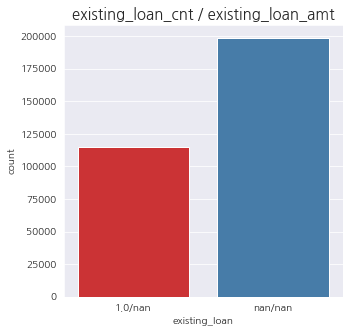

In [ ]:
# 결측값 데이터 추출
df_na = user_spec[(user_spec.existing_loan_cnt.isna())|(user_spec.existing_loan_amt.isna())].reset_index()
df_na['existing_loan'] = df_na['existing_loan_cnt'].astype(str) + '/' +df_na['existing_loan_amt'].astype(str)

# 시각화
plt.figure(figsize=(5, 5)) # 가로, 세로 
sns.countplot(x='existing_loan', palette='Set1', data=df_na)
plt.title('existing_loan_cnt / existing_loan_amt', fontsize=15)
plt.show()

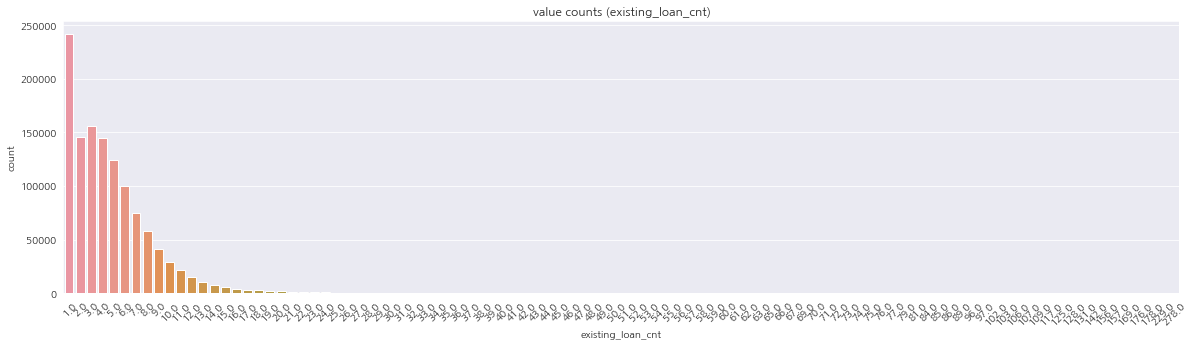

In [ ]:
data = user_spec.existing_loan_cnt.value_counts().sort_index()

plt.figure(figsize=(20, 5)) # 가로, 세로 
sns.barplot(x=data.index, y=data)   
plt.xlabel("existing_loan_cnt")
plt.ylabel("count")
plt.xticks(rotation=45)
plt.title('value counts (existing_loan_cnt)')  
plt.show()

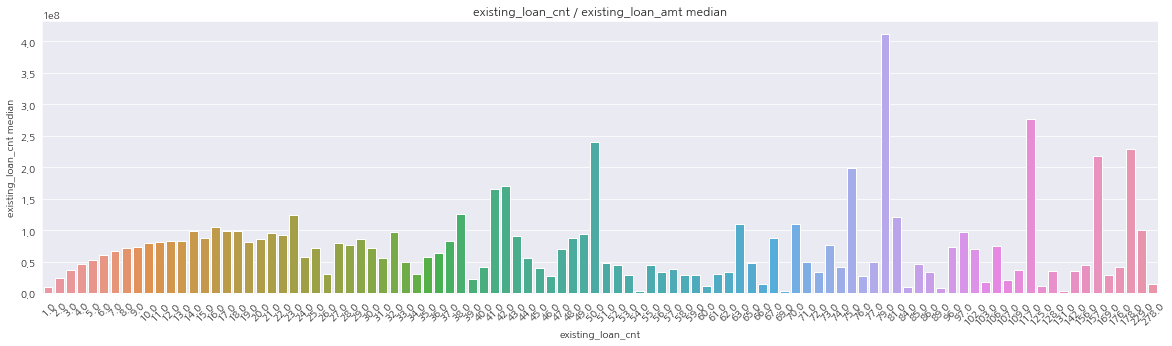

In [ ]:
data = user_spec.groupby('existing_loan_cnt')['existing_loan_amt'].median()

plt.figure(figsize=(20, 5)) # 가로, 세로 
sns.barplot(x=data.index, y=data)   
plt.xticks(rotation=45)
plt.title('existing_loan_cnt / existing_loan_amt median')  
plt.ylabel("existing_loan_cnt median")
plt.show()

중앙값: 10000000.0


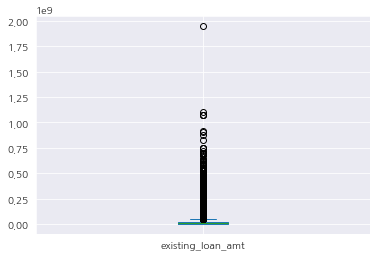

In [ ]:
df_sub = user_spec[user_spec.existing_loan_cnt == 1]
df_sub.existing_loan_amt.plot(kind='box')
print('중앙값:', np.median(df_sub[(~df_sub.existing_loan_amt.isna())].existing_loan_amt))

### 2.1.5. yearly_income 결측치 확인

- 하나의 행에 여러개의 결측치 존재
- loan_result에 존재하지 않는 application_id 였음 

In [ ]:
user_spec[user_spec.yearly_income.isna()]

,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,personal_rehabilitation
148157,1191110,4325,1981.0,1.0,2022-06-13 16:48:01,650.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,217000000.0,nan/nan
1002244,1290239,10768,1993.0,0.0,2022-06-16 16:31:39,590.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,nan/nan
1059249,1870377,18988,1983.0,1.0,2022-03-13 01:34:41,640.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,107000000.0,nan/nan
194824,1862054,21121,1993.0,0.0,2022-04-18 20:14:41,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan/nan
568137,1112045,21121,1993.0,0.0,2022-04-25 07:43:32,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan/nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373054,872487,827892,1993.0,1.0,2022-06-16 16:34:51,940.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,61000000.0,nan/nan
970860,47667,839689,1995.0,1.0,2022-06-16 16:29:15,770.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,16000000.0,nan/nan
1363322,657920,839689,1995.0,1.0,2022-06-16 16:31:02,770.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,16000000.0,nan/nan
1056590,131509,841980,1997.0,0.0,2022-03-31 16:14:22,680.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,19000000.0,nan/nan


## 2.2. user_spec 전처리

In [ ]:
def f_personal_rehabilitation(x):
  if x == '1.0/0.0': return 1
  elif x == '1.0/1.0': return 2
  else: return 0

def preprocessing_user_spec(user_spec):
  user_spec = user_spec.sort_values(['user_id','insert_time']) # 데이터 정렬

  '''
  개인회생(personal_rehabilitation) 변수 생성
  개인회생자가 아닌 경우 : (0,0), (0,Nan), (Nan,Nan), (0,1) -> 0
  개인회생자인데 납입중 : (1,0) -> 1
  개인회생자인데 납입 완료 : (1,1) -> 2
  '''

  user_spec['personal_rehabilitation'] = user_spec['personal_rehabilitation_yn'].astype(str) + '/' +user_spec['personal_rehabilitation_complete_yn'].astype(str)
  user_spec['personal_rehabilitation'] = user_spec['personal_rehabilitation'].apply(f_personal_rehabilitation)
  user_spec.drop(columns=['personal_rehabilitation_yn','personal_rehabilitation_complete_yn'], inplace=True) # 컬럼 제거

  '''
  기대출수, 기대출수 결측치 보간
  (1, nan)인 경우 : (1, 기대출 수가 1인 경우의 기대출금액의 중앙값)으로 채움
  (nan, nan)인 경우 : 대출이 없다고 가정하여 (0, 0)으로 채움
  '''

  user_spec['existing_loan_cnt'] = user_spec['existing_loan_cnt'].fillna(0)
  user_spec['existing_loan_amt'] = user_spec['existing_loan_amt'].fillna('None')

  col_list = []

  for i in range(len(user_spec)):
    existing_loan_cnt = user_spec.existing_loan_cnt.iloc[i]
    existing_loan_amt = user_spec.existing_loan_amt.iloc[i]
    
    if existing_loan_amt == 'None':

      if existing_loan_cnt == 0:
        col_list.append(0)

      elif existing_loan_cnt == 1:
        col_list.append(10000000)

    else:
      col_list.append(existing_loan_amt)

  user_spec['existing_loan_amt'] = col_list

  '''
  user_id 별 이전값으로 보간
  '''

  ndf = []
  for idx, df in tqdm(user_spec.groupby('user_id')):
    ndf.append(df.fillna(method='ffill'))

  user_spec = pd.concat(ndf, axis = 0, ignore_index=True)

  '''
  user_id 별 이후값으로 보간
  '''

  ndf = []
  for idx, df in tqdm(user_spec.groupby('user_id')):
    ndf.append(df.fillna(method='bfill'))

  user_spec = pd.concat(ndf, axis = 0, ignore_index=True)

  '''
  yearly_income 결측치 제거
  '''

  user_spec = user_spec.dropna(subset=['yearly_income']) # yearly_income 결측값인 행 제거 
  user_spec.reset_index(drop=True, inplace=True) # 인덱스 초기화

  '''
  KNN 결측치 보간
  '''

  col_names = ['birth_year', 'gender', 'credit_score', 'yearly_income', 
             'income_type', 'company_enter_month', 'employment_type', 'houseown_type', 
             'desired_amount', 'purpose', 'existing_loan_cnt', 'existing_loan_amt', 
             'personal_rehabilitation']

  knn_data = user_spec[col_names] # knn data 생성 

  # label encoding
  label_col = knn_data.select_dtypes('object').columns
  label_dict = {}

  for i in label_col:
      label_dict[i] = {val : idx for idx, val in enumerate(knn_data[i].unique())}
      knn_data[i] = knn_data[i].map(label_dict[i])

  # knn
  imputer = KNNImputer(n_neighbors=1)
  knn_data = imputer.fit_transform(knn_data)

  # 데이터프레임으로 변환
  knn_data = pd.DataFrame(knn_data)
  knn_data.columns = col_names

  #역변환
  for i in label_col:
      inv_map = {v: k for k, v in label_dict[i].items()}
      knn_data[i] = knn_data[i].map(inv_map)
      
  # 제거했던 컬럼 추가
  knn_data['application_id'] = user_spec['application_id']
  knn_data['user_id'] = user_spec['user_id']
  knn_data['insert_time'] = user_spec['insert_time']

  return knn_data

In [ ]:
user_spec = preprocessing_user_spec(user_spec)

100%|██████████| 405213/405213 [04:52<00:00, 1387.37it/s]


In [3]:
user_spec.isna().sum()

birth_year                 0
gender                     0
credit_score               0
yearly_income              0
income_type                0
company_enter_month        0
employment_type            0
houseown_type              0
desired_amount             0
purpose                    0
existing_loan_cnt          0
existing_loan_amt          0
personal_rehabilitation    0
application_id             0
user_id                    0
insert_time                0
dtype: int64

# 3. 고객 군집 분석

## 3.1. log_data 전처리: event 빈도 합계 테이블로 변환

In [ ]:
def create_clustering_log_data(log_data):
  log_data = log_data.drop(['timestamp', 'mp_os', 'mp_app_version', 'date_cd'],axis=1)
  log_data = pd.get_dummies(log_data, columns = ['event'])

  id_list = []
  ndf = []

  for idx, df in tqdm(log_data.groupby(['user_id'])):
    id_list.append(int(df.user_id.unique()))
    df = df.drop(['user_id'],axis=1)
    ndf.append(pd.DataFrame(df.sum()).transpose())

  log_data = pd.concat(ndf, axis = 0, ignore_index=True)
  log_data['user_id'] = id_list

  log_data.columns = ['CompleteIDCertification', 'EndLoanApply',
       'GetCreditInfo', 'Login', 'OpenApp', 'SignUp',
       'StartLoanApply', 'UseDSRCalc', 'UseLoanManage',
       'UsePrepayCalc', 'ViewLoanApplyIntro', 'user_id']

  return log_data

In [ ]:
clustering_log_data = create_clustering_log_data(log_data)

## 3.2. log_data 전처리: event 발생 비율로 변환

In [ ]:
# log_data 분포 시각화 함수
def dist_log_data(log_data):
  col_list = ['CompleteIDCertification', 'EndLoanApply',
        'GetCreditInfo', 'Login', 'OpenApp', 'SignUp',
        'StartLoanApply', 'UseDSRCalc', 'UseLoanManage',
        'UsePrepayCalc', 'ViewLoanApplyIntro']

  fig = plt.figure(figsize=(25, 25))

  for i in range(len(col_list)):
    col = col_list[i]
    ax = fig.add_subplot(4, 3, i+1)
    sns.distplot(log_data[col])
    plt.title(col, fontsize=15)

  plt.show()

# log_data 변환 함수
def trans_rate_log_data(log_data):
  log_data['event_sum'] = log_data['CompleteIDCertification'] + log_data['EndLoanApply'] + log_data['GetCreditInfo'] + \
                          log_data['Login'] + log_data['OpenApp'] + log_data['SignUp'] + \
                          log_data['StartLoanApply'] + log_data['UseDSRCalc'] + log_data['UseLoanManage'] + \
                          log_data['UsePrepayCalc'] + log_data['ViewLoanApplyIntro']

  log_data['CompleteIDCertification'] = log_data['CompleteIDCertification'] / log_data['event_sum']
  log_data['EndLoanApply'] = log_data['EndLoanApply'] / log_data['event_sum']
  log_data['GetCreditInfo'] = log_data['GetCreditInfo'] / log_data['event_sum']
  log_data['Login'] = log_data['Login'] / log_data['event_sum']
  log_data['OpenApp'] = log_data['OpenApp'] / log_data['event_sum']
  log_data['SignUp'] = log_data['SignUp'] / log_data['event_sum']
  log_data['StartLoanApply'] = log_data['StartLoanApply'] / log_data['event_sum']
  log_data['UseDSRCalc'] = log_data['UseDSRCalc'] / log_data['event_sum']
  log_data['UseLoanManage'] = log_data['UseLoanManage'] / log_data['event_sum']
  log_data['UsePrepayCalc'] = log_data['UsePrepayCalc'] / log_data['event_sum']
  log_data['ViewLoanApplyIntro'] = log_data['ViewLoanApplyIntro'] / log_data['event_sum']

  log_data = log_data.drop(['event_sum'],axis=1)

  return log_data

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

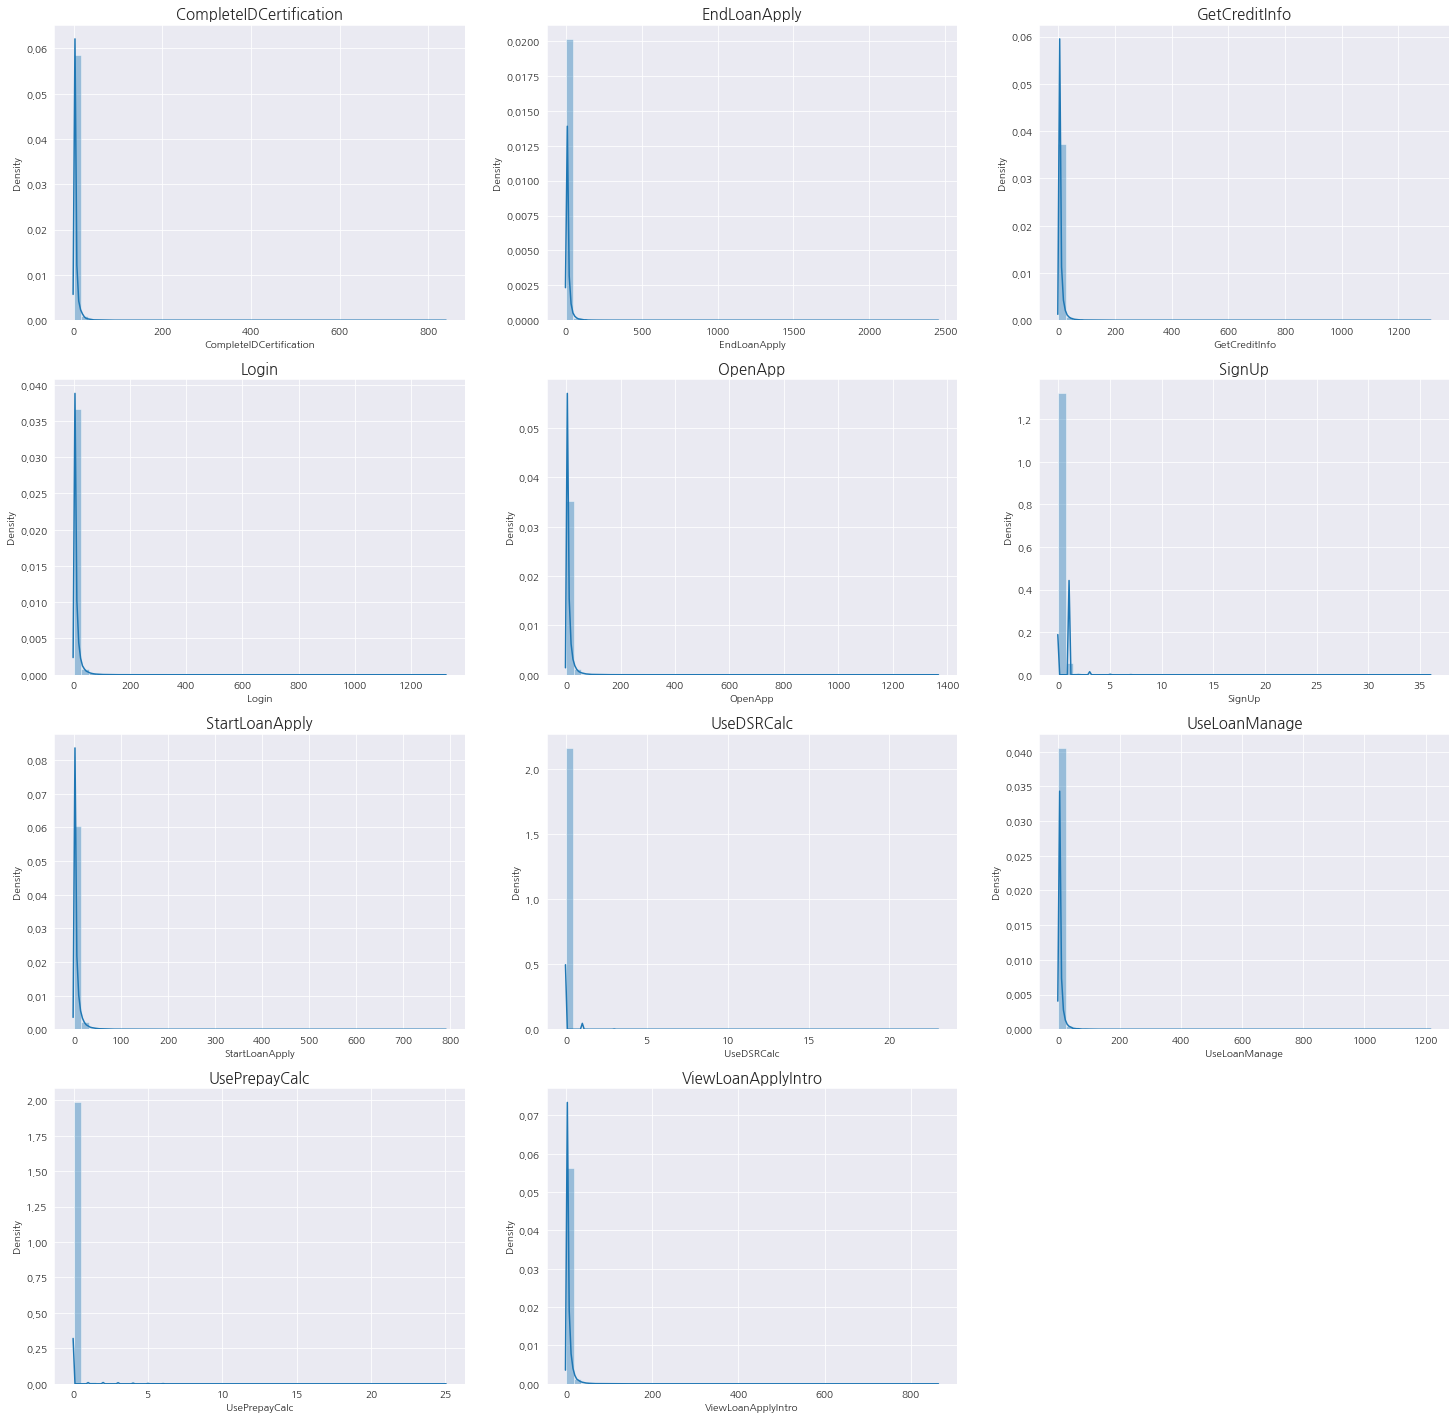

In [ ]:
dist_log_data(clustering_log_data) # 변환 전 분포 시각화

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

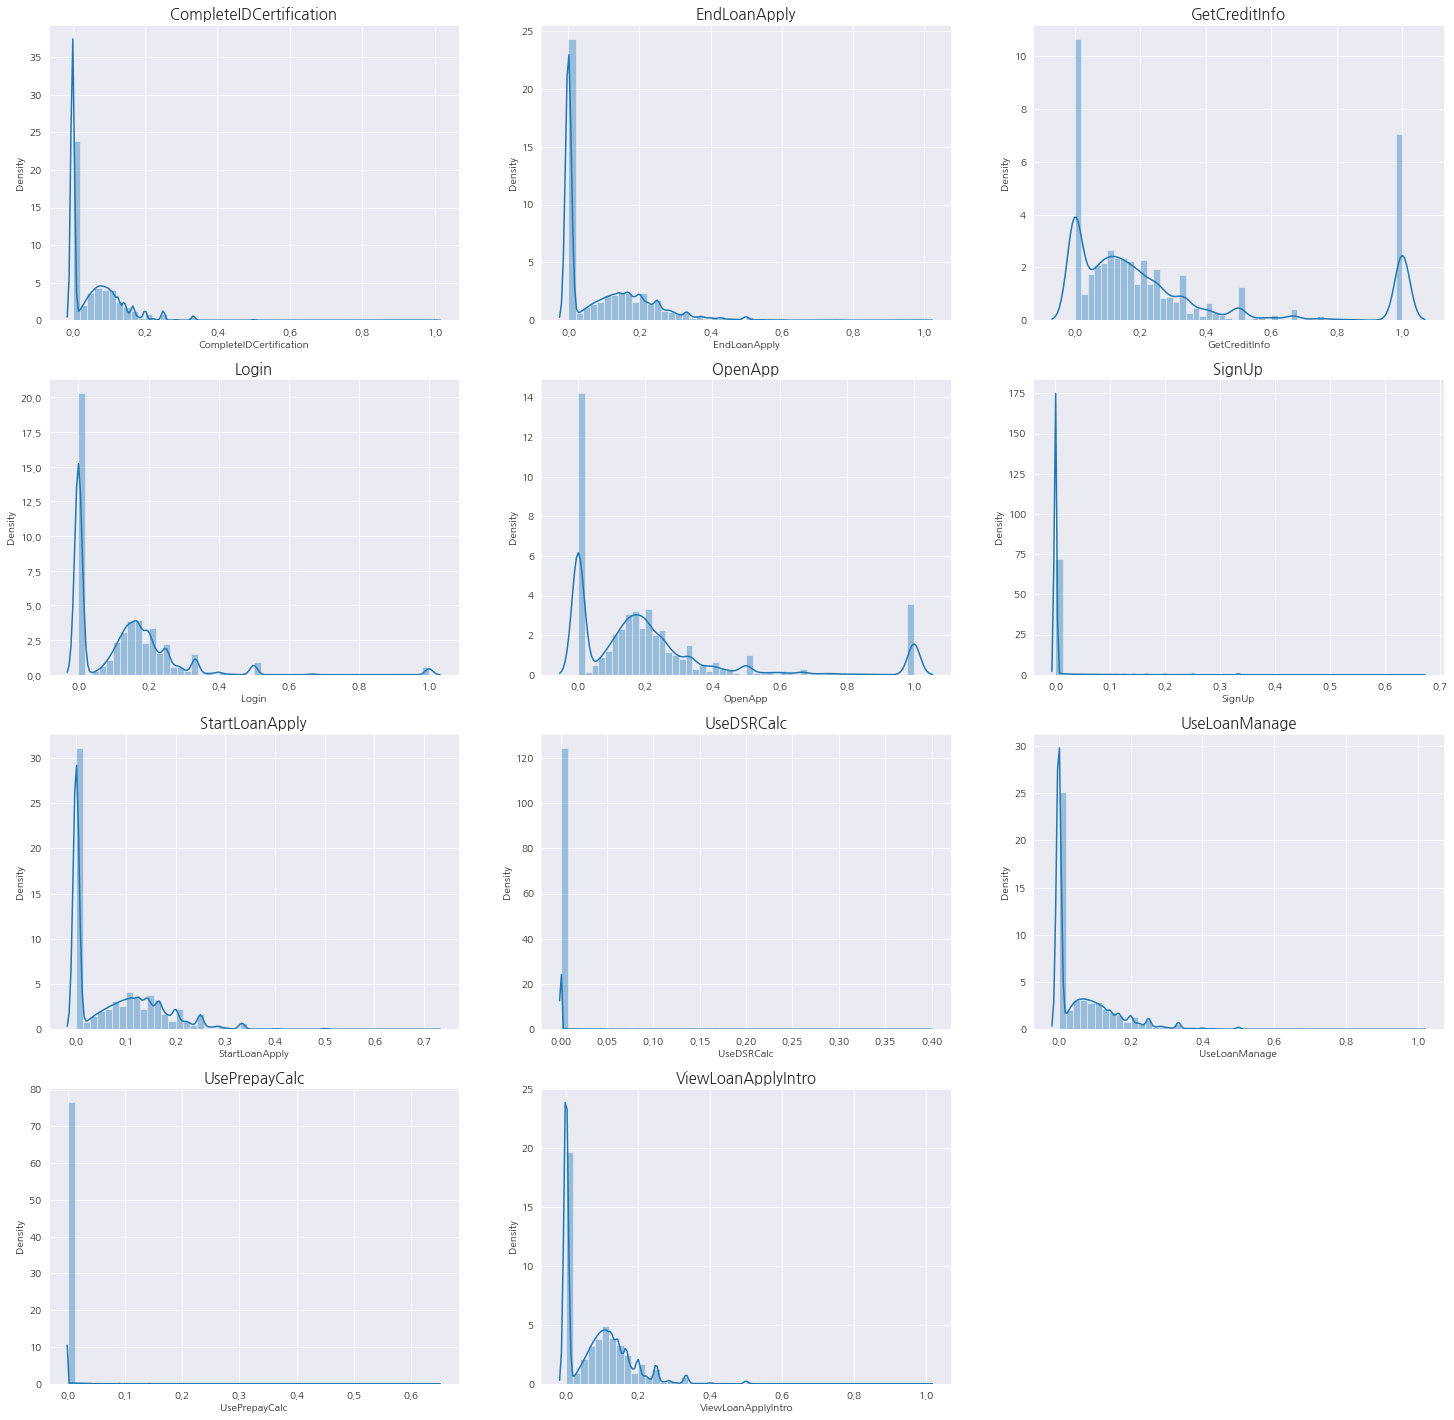

In [ ]:
clustering_log_data = trans_rate_log_data(clustering_log_data) # 발생 비율로 변환
dist_log_data(clustering_log_data) # 변환 후 분포 시각화

## 3.3. K-Means + Elbow Method

In [ ]:
# clustering data, user_id 분리 
user_id_data = clustering_log_data['user_id']
clustering_data = clustering_log_data.drop(['user_id'],axis=1)

# K-Means
elbow_data = []

for n_clusters in range (2,11,1):
  km = KMeans(n_clusters = n_clusters, random_state = 10)
  labels = km.fit_predict(clustering_data)

  elbow_data.append((n_clusters, km.inertia_))

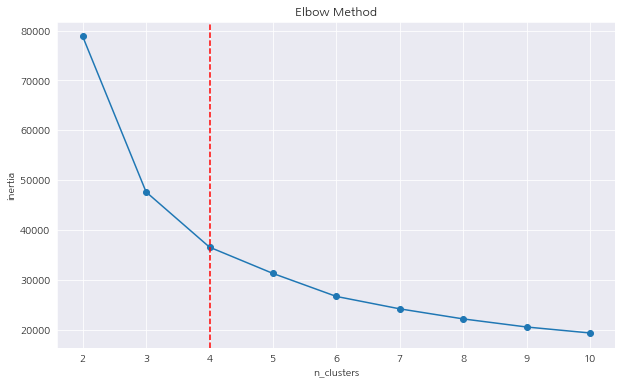

In [ ]:
elbow_df = pd.DataFrame(elbow_data, columns=['n_clusters', 'inertia'])

x = elbow_df['n_clusters']
y = elbow_df['inertia']

plt.figure(figsize=(10,6))
plt.plot(x, y, '-o')
plt.title('Elbow Method')
plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.xticks(x)

plt.axvline(x=4, color='r', linestyle='--')

plt.show()

## 3.4. Clustering 결과 

In [ ]:
km = KMeans(n_clusters = 4, random_state = 10)
labels = km.fit_predict(clustering_data)
clustering_log_data['labels'] = labels # log_data에 cluster 파생 변수 추가

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


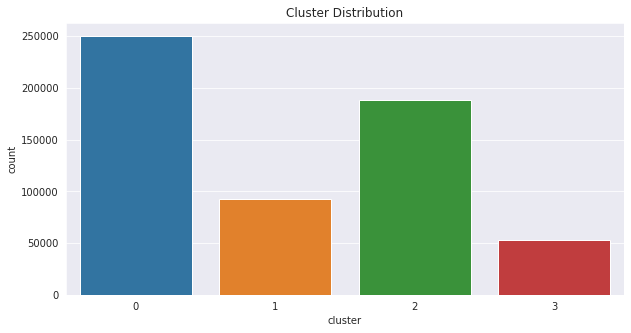

In [ ]:
# count plot
plt.figure(figsize=(10,5))
plt.title("Cluster Distribution")

cluter_count = pd.value_counts(labels).sort_index()
x = cluter_count.index
y = cluter_count.values
sns.barplot(x, y)

plt.xlabel('cluster')
plt.ylabel('count')

plt.show()

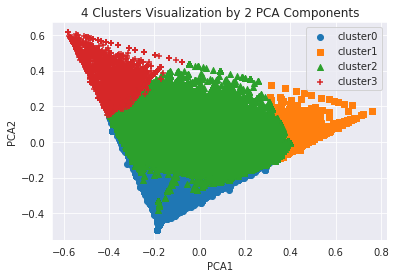

In [ ]:
# PCA scatter 
pca = PCA(n_components = 2)
pca_transformed = pca.fit_transform(clustering_data)

pca_df = pd.DataFrame()
pca_df['pca_x'] = pca_transformed[:, 0]  
pca_df['pca_y'] = pca_transformed[:, 1]  
pca_df['labels'] = labels

marker0 = pca_df[pca_df.labels == 0].index
marker1 = pca_df[pca_df.labels == 1].index
marker2 = pca_df[pca_df.labels == 2].index
marker3 = pca_df[pca_df.labels == 3].index

sns.set_style('darkgrid')

#scatter plot
plt.scatter(x = pca_df.loc[marker0, 'pca_x'], y = pca_df.loc[marker0, 'pca_y'], marker = 'o')
plt.scatter(x = pca_df.loc[marker1, 'pca_x'], y = pca_df.loc[marker1, 'pca_y'], marker = 's')
plt.scatter(x = pca_df.loc[marker2, 'pca_x'], y = pca_df.loc[marker2, 'pca_y'], marker = '^')
plt.scatter(x = pca_df.loc[marker3, 'pca_x'], y = pca_df.loc[marker3, 'pca_y'], marker = '+')
 
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('4 Clusters Visualization by 2 PCA Components')
plt.legend(['cluster0', 'cluster1', 'cluster2', 'cluster3'])
plt.show()

## 3.5. 군집 별 log_data 시각화

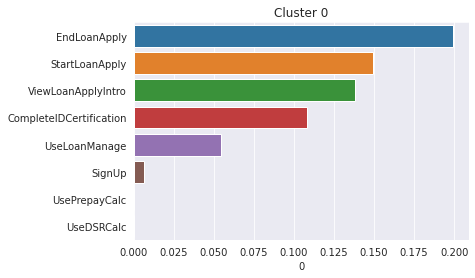

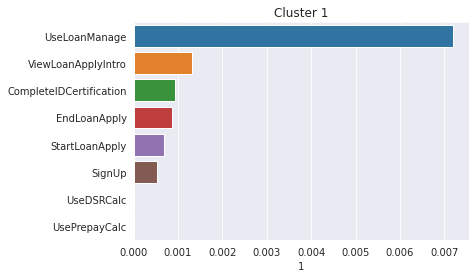

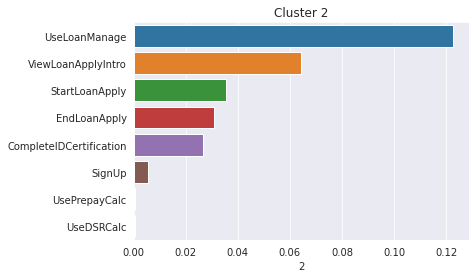

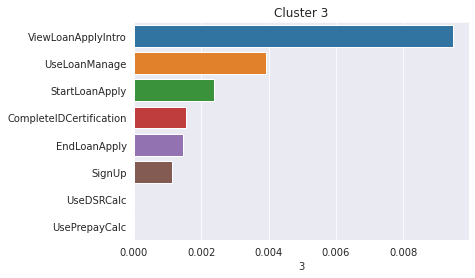

In [ ]:
# 불필요한 컬럼 제거 후 시각화
x = clustering_log_data.drop(['user_id', 'OpenApp', 'GetCreditInfo', 'Login'],axis=1).groupby('labels').mean().transpose()

for i in [0,1,2,3]:
  data = x[i].sort_values(ascending=False)
  sns.barplot(x=data, y=data.index)   
  plt.title('Cluster '+ str(i))  
  plt.show()

## 3.6. 군집 별 user_spec 시각화

In [ ]:
# 가장 최근 user spec 추출 함수
def create_user_spec_unique(user_spec):
  ndf = []
  for idx, df in tqdm(user_spec.groupby('user_id')):
    ndf.append(pd.DataFrame(df.iloc[-1]).transpose())

  user_spec = pd.concat(ndf, axis = 0, ignore_index=True)

  return user_spec

# 군집 별 user_spec barplot 시각화 함수 
def cluster_barplot(user_spec, col):
  fig = plt.figure(figsize=(35, 5))  

  for i in range(4):
    ax = fig.add_subplot(1, 4, i+1)

    data = user_spec[user_spec.labels == i] # cluster data 추출
    data = data[col].value_counts().sort_values(ascending=False)
    sns.barplot(x=data, y=data.index, orient='h', ax=ax)   

    plt.title('Cluster {0}: {1}'.format(i,col), fontsize=15)

  plt.show()

#한글폰트 설정
sns.set_style('darkgrid')
plt.rc('font', family='NanumGothic')

In [ ]:
user_spec_unique = create_user_spec_unique(user_spec) # 가장 최근 user spec data 생성

In [ ]:
# user_spec에 군집 파생변수 생성  
cluster_id_df = clustering_log_data[['user_id', 'labels']]
user_spec_unique = pd.merge(user_spec_unique, cluster_id_df, how='inner',on='user_id')

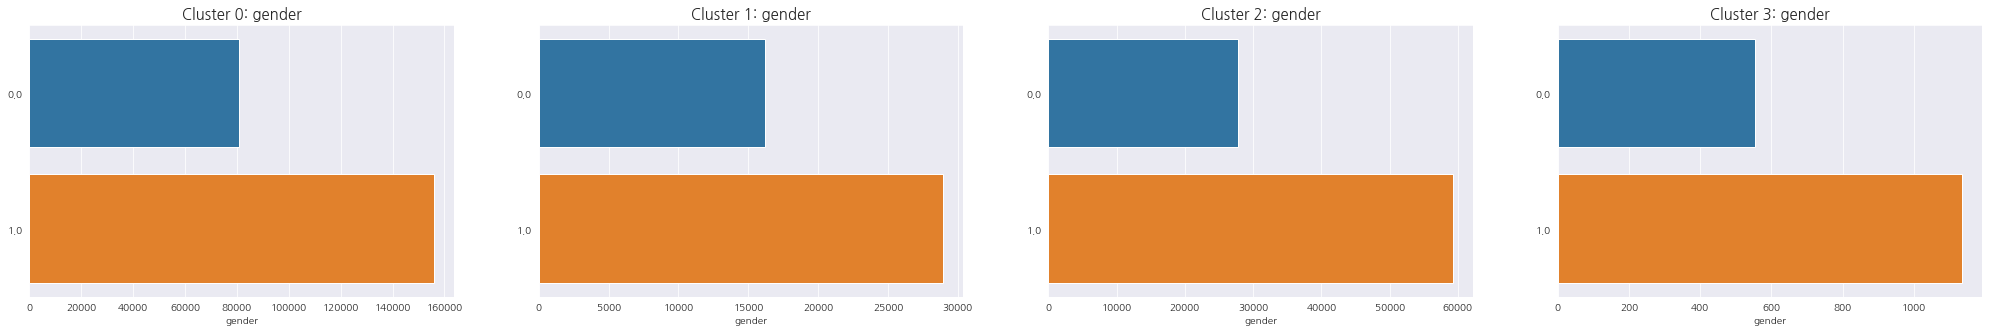

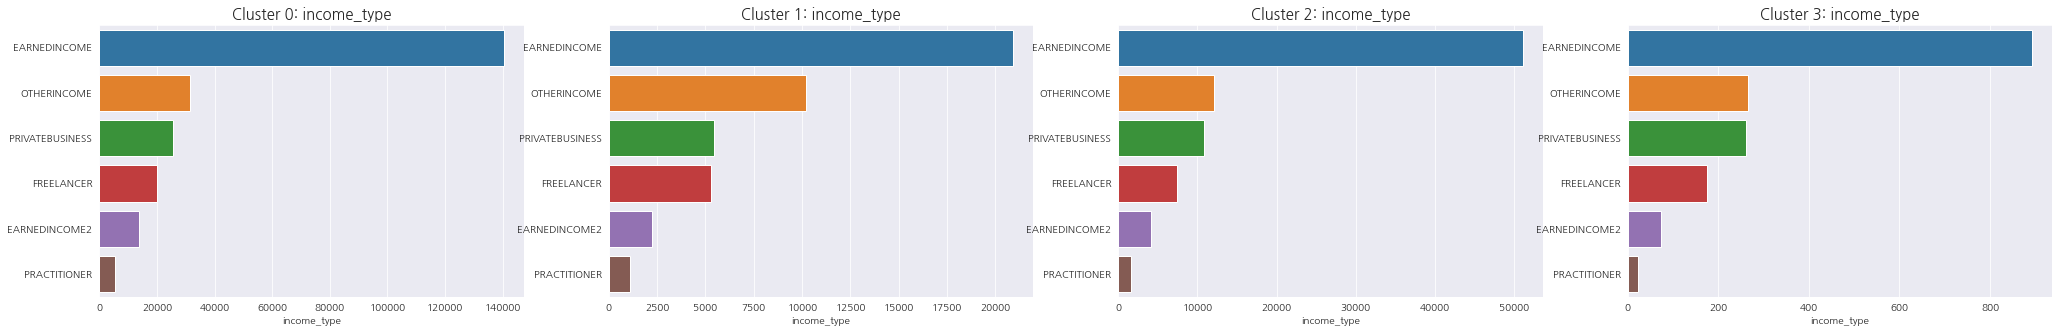

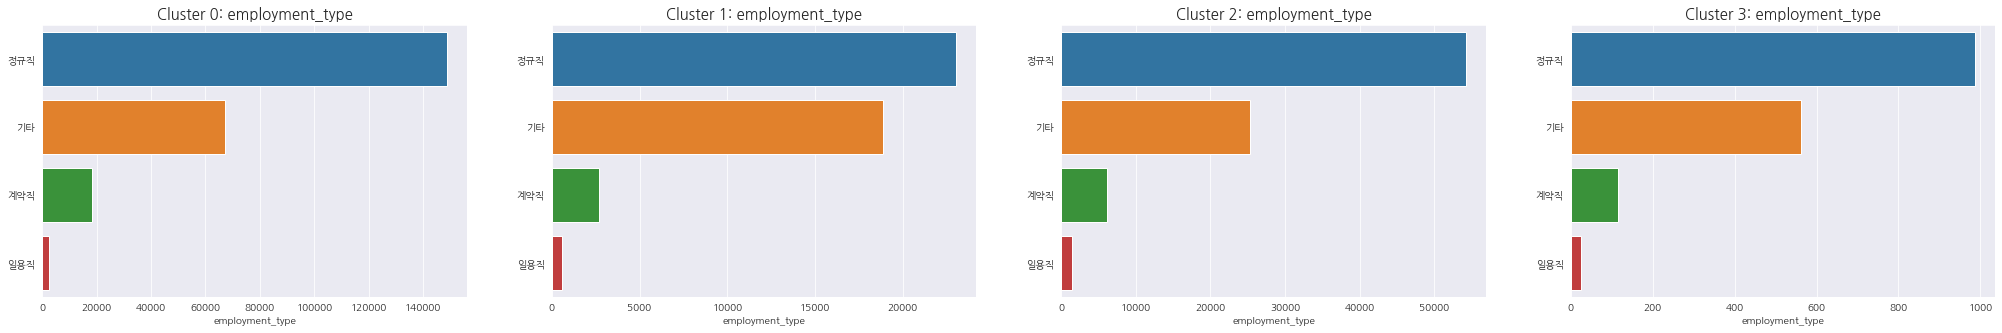

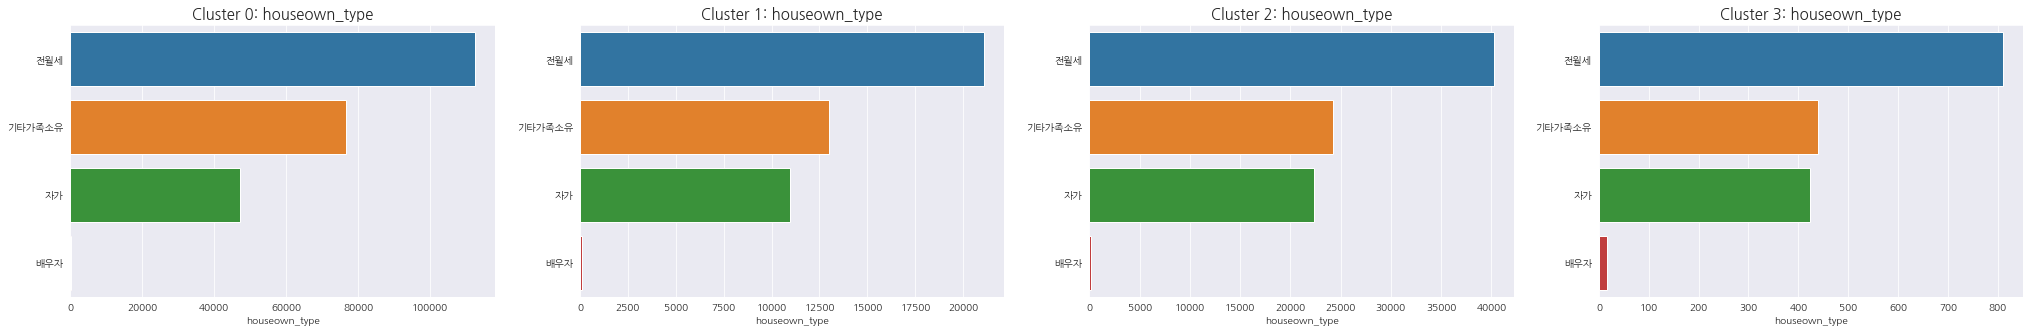

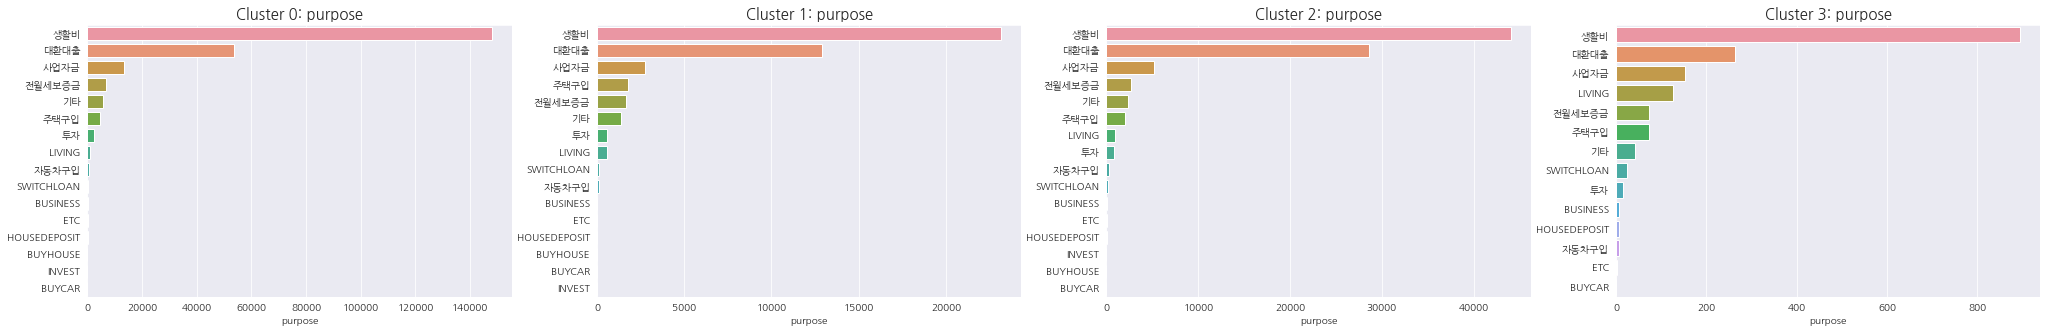

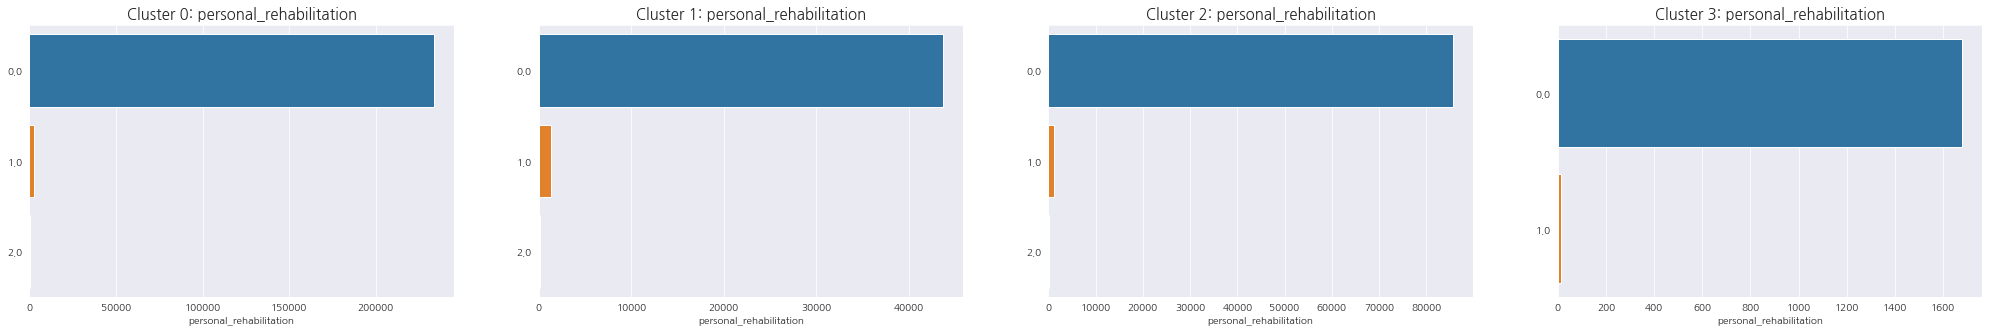

In [ ]:
# 군집 별 barplot 시각화
col_list = ['gender', 'income_type', 'employment_type', 'houseown_type', 'purpose', 'personal_rehabilitation']

for col in col_list:
  cluster_barplot(user_spec_unique, col)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

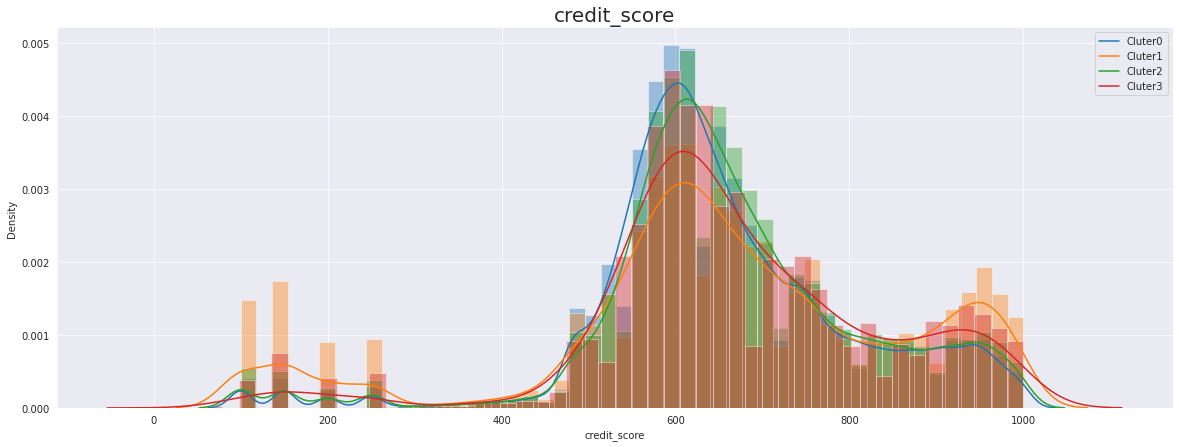

In [ ]:
sns.set_style('darkgrid')

col = 'credit_score'

plt.figure(figsize=(20, 7)) 

sns.distplot(user_spec_unique[user_spec_unique.labels == 0][col], bins = 50)
sns.distplot(user_spec_unique[user_spec_unique.labels == 1][col], bins = 50)
sns.distplot(user_spec_unique[user_spec_unique.labels == 2][col], bins = 50)
sns.distplot(user_spec_unique[user_spec_unique.labels == 3][col], bins = 50)

plt.title(col, fontsize=20)
plt.legend(['Cluter0','Cluter1','Cluter2','Cluter3'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

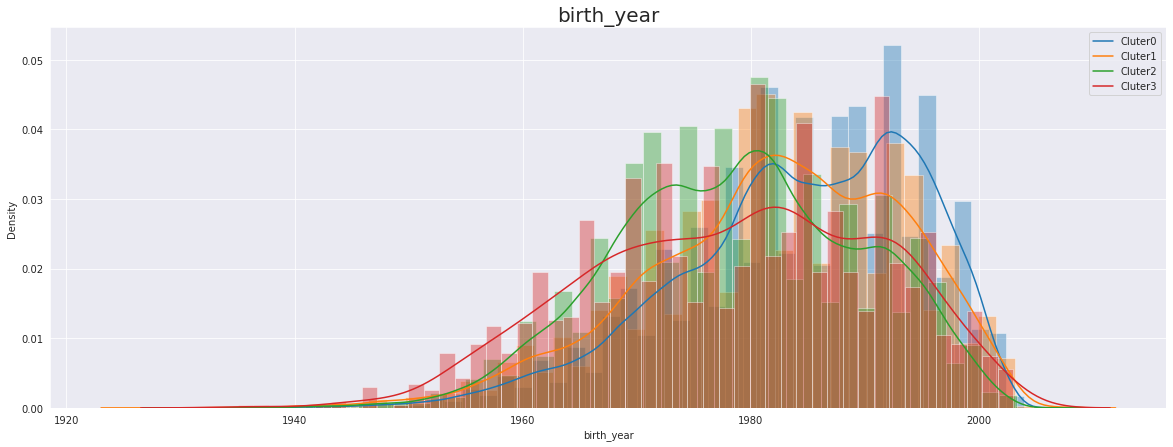

In [ ]:
col = 'birth_year'

plt.figure(figsize=(20, 7)) 

sns.distplot(user_spec_unique[user_spec_unique.labels == 0][col], bins = 50)
sns.distplot(user_spec_unique[user_spec_unique.labels == 1][col], bins = 50)
sns.distplot(user_spec_unique[user_spec_unique.labels == 2][col], bins = 50)
sns.distplot(user_spec_unique[user_spec_unique.labels == 3][col], bins = 50)

plt.title(col, fontsize=20)
plt.legend(['Cluter0','Cluter1','Cluter2','Cluter3'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

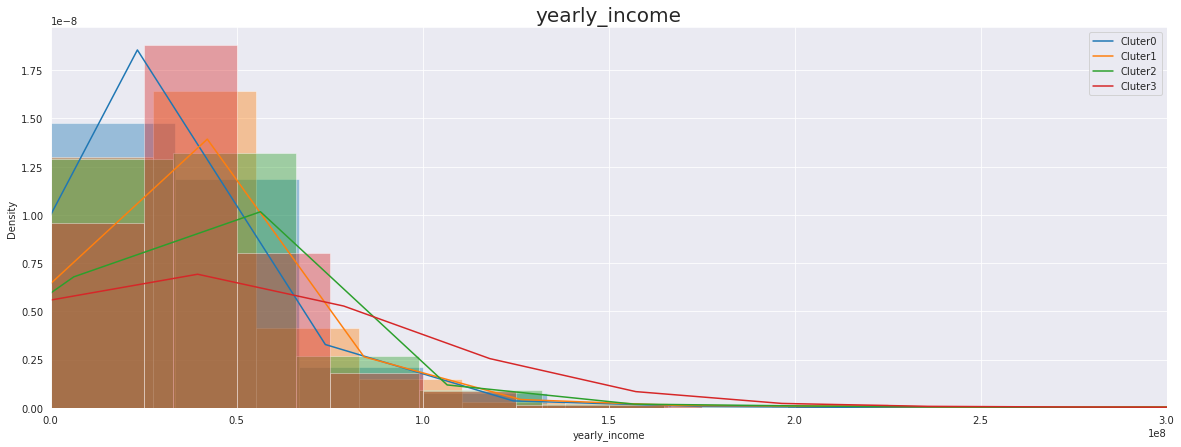

In [ ]:
col = 'yearly_income'

plt.figure(figsize=(20, 7)) 

sns.distplot(user_spec_unique[user_spec_unique.labels == 0][col], bins = 300)
sns.distplot(user_spec_unique[user_spec_unique.labels == 1][col], bins = 300)
sns.distplot(user_spec_unique[user_spec_unique.labels == 2][col], bins = 300)
sns.distplot(user_spec_unique[user_spec_unique.labels == 3][col], bins = 300)

plt.xlim([0,3e8])
plt.title(col, fontsize=20)
plt.legend(['Cluter0','Cluter1','Cluter2','Cluter3'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

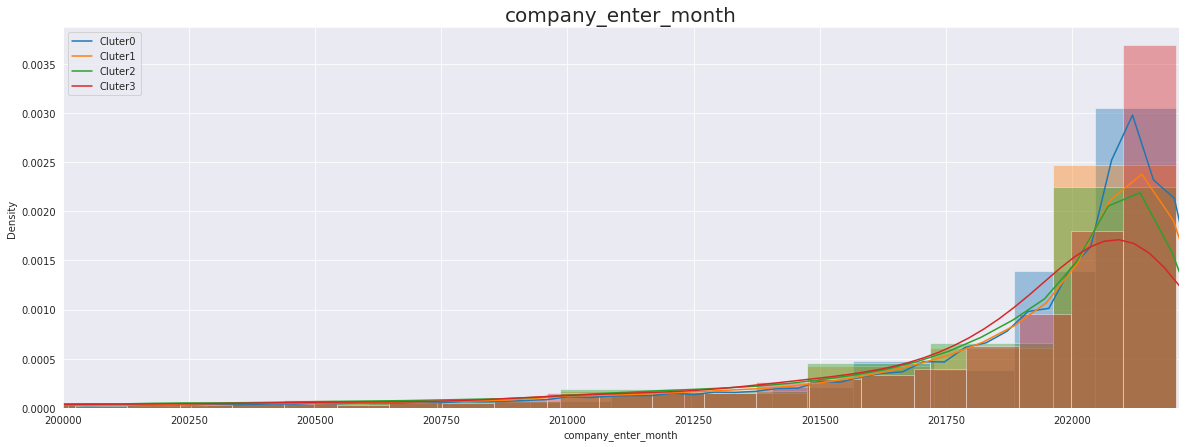

In [ ]:
col = 'company_enter_month'

plt.figure(figsize=(20, 7)) 

sns.distplot(user_spec_unique[user_spec_unique.labels == 0][col], bins = 50)
sns.distplot(user_spec_unique[user_spec_unique.labels == 1][col], bins = 50)
sns.distplot(user_spec_unique[user_spec_unique.labels == 2][col], bins = 50)
sns.distplot(user_spec_unique[user_spec_unique.labels == 3][col], bins = 50)

plt.xlim([200000,202212])
plt.title(col, fontsize=20)
plt.legend(['Cluter0','Cluter1','Cluter2','Cluter3'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

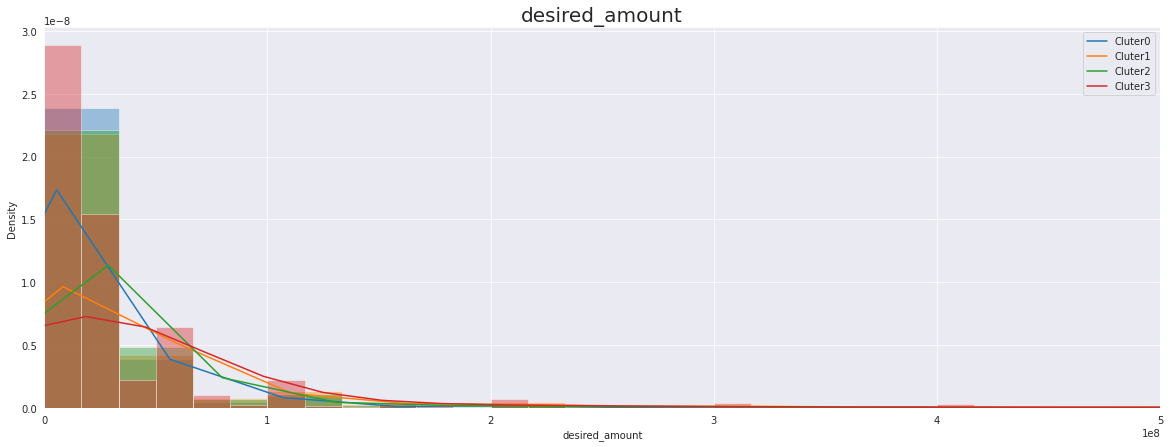

In [ ]:
col = 'desired_amount'

plt.figure(figsize=(20, 7)) 

sns.distplot(user_spec_unique[user_spec_unique.labels == 0][col], bins = 300)
sns.distplot(user_spec_unique[user_spec_unique.labels == 1][col], bins = 300)
sns.distplot(user_spec_unique[user_spec_unique.labels == 2][col], bins = 300)
sns.distplot(user_spec_unique[user_spec_unique.labels == 3][col], bins = 300)

plt.xlim([0,0.5e9])
plt.title(col, fontsize=20)
plt.legend(['Cluter0','Cluter1','Cluter2','Cluter3'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

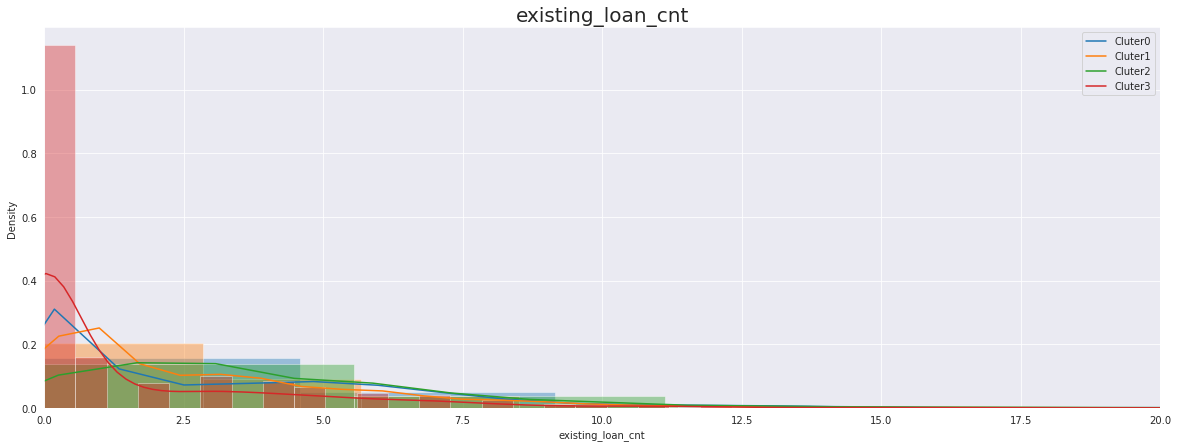

In [ ]:
col = 'existing_loan_cnt'

plt.figure(figsize=(20, 7)) 

sns.distplot(user_spec_unique[user_spec_unique.labels == 0][col], bins = 50)
sns.distplot(user_spec_unique[user_spec_unique.labels == 1][col], bins = 50)
sns.distplot(user_spec_unique[user_spec_unique.labels == 2][col], bins = 50)
sns.distplot(user_spec_unique[user_spec_unique.labels == 3][col], bins = 50)

plt.xlim([0,20])
plt.title(col, fontsize=20)
plt.legend(['Cluter0','Cluter1','Cluter2','Cluter3'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

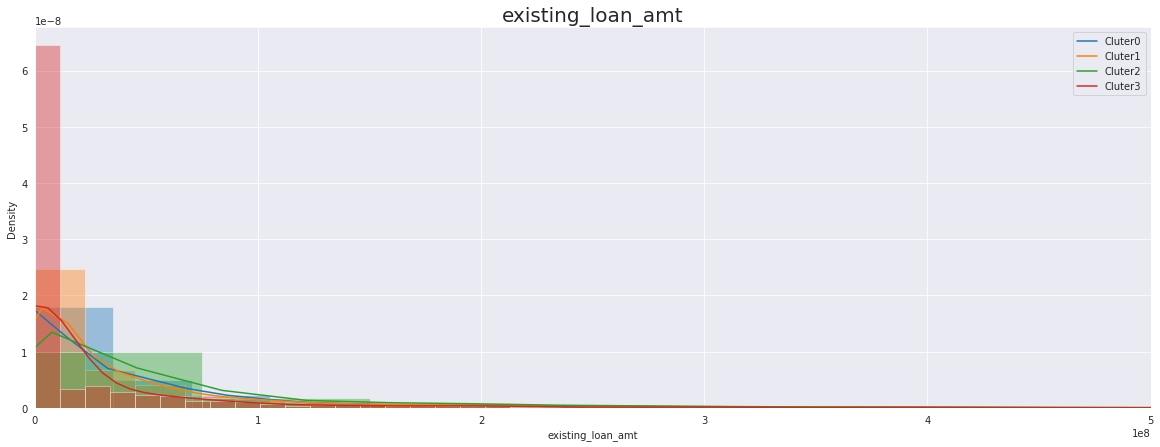

In [ ]:
col = 'existing_loan_amt'

plt.figure(figsize=(20, 7)) 

sns.distplot(user_spec_unique[user_spec_unique.labels == 0][col], bins = 100)
sns.distplot(user_spec_unique[user_spec_unique.labels == 1][col], bins = 100)
sns.distplot(user_spec_unique[user_spec_unique.labels == 2][col], bins = 100)
sns.distplot(user_spec_unique[user_spec_unique.labels == 3][col], bins = 100)

plt.xlim([0,0.5e9])
plt.title(col, fontsize=20)
plt.legend(['Cluter0','Cluter1','Cluter2','Cluter3'])
plt.show()